# ImageNet with KerasTuner

In [1]:
import cifar10_loader
import matplotlib.pyplot as plt

In [2]:
train_x, train_y, val_x, val_y = cifar10_loader.load_data(limit=5, shuffle=True)

In [3]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(49900, 32, 32, 3)
(49900,)
(100, 32, 32, 3)
(100,)


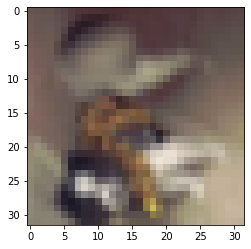

In [4]:
plt.imshow(train_x[0])

In [5]:
import tensorflow as tf
import kerastuner as kt

In [10]:
def get_modified_inception_net(hp):
    # Tuner params
    image_size = hp.Int('image_size', min_value=75, max_value=400, step=150)
    train_layer_limit = hp.Choice('trainable_layer', values=[0, 5, 10])
    # Model
    inception_net = tf.keras.applications.inception_v3.InceptionV3(
        input_shape=(image_size, image_size, 3),
        include_top=False,
        weights='imagenet'
    )
    if train_layer_limit == 0:
        for layer in inception_net.layers:
            layer.trainable = False
    else:
        for layer in inception_net.layers[train_layer_limit:]:
            layer.trainable = False
    my_inception_net_model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size))),
        inception_net,
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(2048, activation='relu'),
        #tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
    my_inception_net_model.compile(adam, 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return my_inception_net_model

In [11]:
tuner = kt.Hyperband(
    get_modified_inception_net,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='saved_models',
    project_name='inceptionnet_cifar10'
)

In [12]:
validation_accuracy_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
)
training_accuracy_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=7,
)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.6,
    patience=2,
    verbose=1,
    mode='max',
    min_lr=1e-7
)
callbacks = [validation_accuracy_callback, training_accuracy_callback, reduce_lr_on_plateau]

In [13]:
tuner.search(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    epochs=100,
    callbacks=callbacks
)

Trial 1 Complete [00h 04m 48s]
val_accuracy: 0.6399999856948853

Best val_accuracy So Far: 0.6399999856948853
Total elapsed time: 00h 04m 48s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
image_size        |225               |75                
trainable_layer   |5                 |5                 
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |0                 |0                 

Epoch 1/2


ResourceExhaustedError:  OOM when allocating tensor with shape[32,96,25,25] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/inception_v3/batch_normalization_24/FusedBatchNormV3 (defined at /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/kerastuner/engine/tuner.py:141) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_58581]

Function call stack:
train_function
